Workflow used for:
  1. Load metadata about GRSs used
  1. Read phenotypic information and consolidate it with raw PGS scores from **apply_grs.ipynb**
  1. Standardize raw scores and calculate Odds Ratios between case/controls
  1. Generate visualization plots

In [1]:
# Import all necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns
import numpy as np
import os, glob
from sklearn import preprocessing
import statsmodels.api as sm
import json
from xlsxwriter.utility import xl_rowcol_to_cell
import glob
import gzip
import zepid
from zepid.graphics import EffectMeasurePlot
import matplotlib.lines as mlines
from statsmodels.stats.multitest import fdrcorrection
import statistics
from scipy.stats import iqr


**Step 1)** Load metadata about GRSs used

In [2]:
os.chdir("/labs/tassimes/rodrigoguarischi/projects/sea/apply_grs/pgs_reference_weights/")

# Load all key/values present on the header of PGS files into a dictionary
pgs_metadata = {}
for current_score_file in glob.glob( "*.txt.gz" ):
    score_name = current_score_file.replace(".txt.gz","")
    pgs_metadata[score_name] = {}
    with gzip.open( current_score_file,'rt') as f:
        for line in f:
            if( ( line.startswith("#") ) & (not line.startswith("##") ) ):
                line = line.strip()
                line = line.replace("#", "")
                key, value = line.split("=")
                pgs_metadata[score_name][key] = value
    if( str( pgs_metadata[score_name]["pgs_id"] ).startswith("PGS") ):
        pgs_metadata[score_name]["pgs_catalog_hyperlink"] = "https://www.pgscatalog.org/score/{0}/".format(pgs_metadata[score_name]["pgs_id"])
    else:
        pgs_metadata[score_name]["pgs_catalog_hyperlink"] = ""

**Step 2)** Read phenotypic information

In [3]:
os.chdir("/labs/tassimes/rodrigoguarischi/projects/sea/")

# Read phenotypes and recode sex and race attributes
sea_phenotypes = pd.read_table(
    "data_preparation_to_imputation/86679/NHLBI/SEA_Herrington/phs000349v1/p1/phenotype/phs000349.v1.pht002191.v1.p1.c1.SEA_Phase2_Subject_Phenotypes.GRU.txt",
    index_col="seaid",
    comment="#")

# Recode Sex and Race
sea_phenotypes = sea_phenotypes.replace( {
    "sex": { 1:"male", 2:"female" },
    "race": { 1:"white", 2:"black" }
    } )

# Cast BMI values to integers
sea_phenotypes = sea_phenotypes.assign( bmi=pd.to_numeric(sea_phenotypes["bmi"], errors="coerce") )

# Drop unnecessary column
sea_phenotypes = sea_phenotypes.drop("dbGaP SubjID", axis = 1)

# Print counts by race and sex and first lines from dataframe 
print( "Statistics by subgroups:" )
print( sea_phenotypes.groupby(["race","sex"])["sex"].count(), "\n" )

# Print some summary statistics
phenotype = "cr"

for race in [ "white", "black"]:
    print( "For " + race + " (" + str( len( sea_phenotypes[ sea_phenotypes["race"] == race ] ) ) + " subjects)" )

    age_values = sea_phenotypes[ sea_phenotypes["race"] == race ]["age"]
    print( "  Age: mean {0:.1f}+-{1:.1f}; median {2:.1f} ".format( age_values.mean(), statistics.stdev( age_values ), age_values.median() ) )

    # BMI dropning NA values (3 subjects)
    bmi_values = sea_phenotypes[ sea_phenotypes["race"] == race ]["bmi"].dropna()
    print( "  BMI: mean {0:.1f}+-{1:.1f}; median {2:.1f} ".format( bmi_values.mean(), statistics.stdev( bmi_values ), bmi_values.median() ) )

    print( "  # of males: " + str( len( sea_phenotypes[ ( sea_phenotypes["race"] == race ) & ( sea_phenotypes["sex"] == "male" ) ] )  ) )
    print( "  # of subjects with RCA = 0: " + str(len( sea_phenotypes[ ( sea_phenotypes["race"] == race ) & ( sea_phenotypes[phenotype] == 0 ) ] ) ) )
    
    surface_area_values = sea_phenotypes[ ( sea_phenotypes["race"] == race ) & ( sea_phenotypes[phenotype] > 0 ) ][phenotype]
    print( "  Of the subjects with RCA > 0, the surface area involvement was mean = {0:.1f}% (SD = {1:.1f}); median = {2:.1f}% (IQR = {3:.1f})\n".format(
        surface_area_values.mean(),
        statistics.stdev( surface_area_values ),
        surface_area_values.median(),
        iqr(surface_area_values)
        ) )
    

# Print final dataframe
sea_phenotypes

# plt.rcParams['figure.dpi']= 150
# sns.set_style('white')

# sns.violinplot(
#     x = "race",
#     y = "bmi_i",
#     hue = "sex",
#     hue_order=['female','male'],
#     split = True,
#     bw=0.5,
#     scale = "count",
#     data = sea_dataset_full
#     )

Statistics by subgroups:
race   sex   
black  female     92
       male      412
white  female    128
       male      436
Name: sex, dtype: int64 

For white (564 subjects)
  Age: mean 26.7+-5.0; median 28.0 
  BMI: mean 25.3+-5.0; median 24.3 
  # of males: 436
  # of subjects with RCA = 0: 383
  Of the subjects with RCA > 0, the surface area involvement was mean = 12.7% (SD = 17.4); median = 5.0% (IQR = 17.0)

For black (504 subjects)
  Age: mean 27.5+-4.3; median 28.0 
  BMI: mean 25.1+-5.1; median 24.3 
  # of males: 412
  # of subjects with RCA = 0: 339
  Of the subjects with RCA > 0, the surface area involvement was mean = 12.9% (SD = 18.4); median = 4.3% (IQR = 16.3)



,sex,race,age,agex2,bmi,tf,tr,af,ar,cf,cr,rltotal,rlmean
seaid,,,,,,,,,,,,,
pd10016,female,white,29,841,19.9,6.7,0.0,10.7,0.0,3.3,0.0,0.0,0.000000
pd10018,male,white,30,900,28.3,27.3,0.0,22.0,0.0,3.4,0.6,0.6,0.200000
pd10023,male,white,27,729,21.7,27.3,0.0,55.0,0.0,4.0,0.0,0.0,0.000000
pd10028,male,black,31,961,29.0,16.0,0.0,36.8,14.8,1.7,1.0,15.8,5.266667
pd10031,male,white,28,784,21.5,20.0,0.0,16.7,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
pd12871,male,white,25,625,26.0,15.0,0.0,9.0,0.0,0.0,0.0,0.0,0.000000
pd12872,male,black,26,676,18.9,53.3,0.0,55.0,0.0,0.0,0.0,0.0,0.000000
pd12873,male,black,17,289,21.9,18.0,0.0,19.0,0.0,3.0,0.0,0.0,0.000000


Step 3) Load **PCA results** to dataframe

In [4]:
os.chdir("/labs/tassimes/rodrigoguarischi/projects/sea/pca_analysis/")

pca_results = {}

pca_results["whites"] = pd.read_table( "pca_whites.eigenvec", sep = "\t" )
pca_results["whites"] = pca_results["whites"].set_index("IID")

pca_results["blacks"] = pd.read_table( "pca_blacks.eigenvec", sep = "\t" )
pca_results["blacks"] = pca_results["blacks"].set_index("IID")

pca_results["all"] = pd.concat( [pca_results["whites"], pca_results["blacks"]], axis=0 ).drop("#FID", axis = 1)

sea_dataset_full = pd.concat( [sea_phenotypes, pca_results["all"]], axis = 1 )
sea_dataset_full

,sex,race,age,agex2,bmi,tf,tr,af,ar,cf,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
pd10016,female,white,29,841,19.9,6.7,0.0,10.7,0.0,3.3,...,-0.006825,0.018891,-0.003455,-0.007874,0.026135,0.019208,0.004665,0.008936,-0.040799,0.000123
pd10018,male,white,30,900,28.3,27.3,0.0,22.0,0.0,3.4,...,-0.008184,0.002899,-0.001910,0.026848,0.019029,0.011589,-0.001970,-0.029758,-0.008889,0.037244
pd10023,male,white,27,729,21.7,27.3,0.0,55.0,0.0,4.0,...,0.021547,-0.017545,-0.011910,0.006369,0.021369,-0.028954,0.028462,0.003554,-0.003874,0.003383
pd10028,male,black,31,961,29.0,16.0,0.0,36.8,14.8,1.7,...,-0.059962,0.025734,0.003848,-0.019902,-0.055411,0.004292,0.046521,0.005009,-0.061828,-0.018428
pd10031,male,white,28,784,21.5,20.0,0.0,16.7,0.0,0.0,...,-0.003675,-0.002468,0.035139,-0.068820,0.086355,-0.012242,-0.072977,-0.018035,-0.090649,0.143556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pd12871,male,white,25,625,26.0,15.0,0.0,9.0,0.0,0.0,...,-0.013646,-0.009487,0.000942,0.008001,0.004313,-0.014603,0.003558,0.020290,-0.006042,0.016711
pd12872,male,black,26,676,18.9,53.3,0.0,55.0,0.0,0.0,...,-0.012626,0.019843,0.022616,0.054914,-0.068902,-0.012065,0.007603,-0.044239,-0.019055,-0.036954
pd12873,male,black,17,289,21.9,18.0,0.0,19.0,0.0,3.0,...,0.014341,0.017928,0.073089,-0.008301,0.052788,0.054721,0.008493,-0.021289,-0.013251,-0.009285
pd12875,male,black,23,529,22.7,17.7,0.0,32.3,0.0,2.3,...,-0.057942,0.152120,-0.119545,0.073026,0.134121,0.099255,-0.018629,0.017820,-0.017232,0.075466


Step 4) Consolidate raw **PGS scores**

In [5]:
# Read files with raw scores of multiple GRSs

li = []
li.append(sea_dataset_full)

os.chdir("/labs/tassimes/rodrigoguarischi/projects/sea/apply_grs/raw_scores_20221229/")

# Loop over info files and save info as a dictionary   
scores_info_dict = {}
for current_info_file in glob.glob( "*.info.txt" ):

    # Parse filename to get info about GRSs.
    # Format should be: <hrc|topmed>_<whites|blacks>_<8-digits_date>_multiGRS_<minr2_used>.info.txt
    min_r2_used = os.path.basename( current_info_file ).split(".")[0].split("_")[-1]
    reference_panel_name = os.path.basename( current_info_file ).split("_")[0]
    race = os.path.basename( current_info_file ).split("_")[1]
    
    f = open( current_info_file )
    data = json.load(f)

    # Load metrics on a dictionary of dictionaries using panel, r2 and PGS name and each race as keys
    for score_result in data:
        key = "_".join( (reference_panel_name, min_r2_used, score_result["name"]) )
        
        # If key doesn't exist yet in the dictionary, create it
        if key not in scores_info_dict:
            scores_info_dict[key] = {}
            
        scores_info_dict[key][race] = score_result

    f.close()

# Loop over scores files, load all into memory and save it to list object 'li'    
for current_score_file in glob.glob( "*.scores.txt" ):
        
    grs_results = pd.read_table( current_score_file, sep = "," )
    grs_results["sample"] = grs_results["sample"].str.split("_", expand = True)[0]
    grs_results = grs_results.set_index("sample")
    min_r2_used = os.path.basename( current_score_file ).split(".")[0].split("_")[-1]
    reference_panel_name = os.path.basename( current_score_file ).split("_")[0]
        
    # Add prefix to column names. Names should match pattern <hrc|topmed>_<threshold>_<scoreid>
    grs_results = grs_results.add_prefix(reference_panel_name + "_" + min_r2_used + "_")

    # Test if this set of scores already exists in li. 
    # If the other race was already loaded, append subjects to the dataframe. Otherwise, append dataframe to li
    new_score_set = True
    for i in range( len(li) ):
        if( set( grs_results.columns ) == set( li[i].columns ) ):
            li[i] = pd.concat( [li[i], grs_results], axis=0 )
            new_score_set = False

    if( new_score_set ):
        li.append( grs_results )

# Consolidate data into a dataframe and print first lines
sea_dataset_full = pd.concat( li, axis=1 )
sea_dataset_full

,sex,race,age,agex2,bmi,tf,tr,af,ar,cf,...,hrc_r05_PGS002114,hrc_r05_PGS001105,hrc_r05_PGS000349,hrc_r05_PGS001917,hrc_r05_PGS001818,hrc_r05_HDL20201014Shoa,hrc_r05_PGS000957,hrc_r05_logTG20201014Shoa,hrc_r05_PGS000889,hrc_r05_PGS000018
pd10016,female,white,29,841,19.9,6.7,0.0,10.7,0.0,3.3,...,-0.892892,1.502699,0.620980,-0.001974,0.047982,0.140237,-0.117173,-1.445465,0.526730,0.688731
pd10018,male,white,30,900,28.3,27.3,0.0,22.0,0.0,3.4,...,-0.549986,-0.350629,0.625468,-0.012930,0.349792,0.277881,0.708726,0.207338,0.650721,1.249112
pd10023,male,white,27,729,21.7,27.3,0.0,55.0,0.0,4.0,...,-0.189287,0.738106,0.293201,0.006961,0.356289,0.049021,0.672221,-0.276397,1.236678,1.026499
pd10028,male,black,31,961,29.0,16.0,0.0,36.8,14.8,1.7,...,0.367120,2.030025,-0.203722,0.006206,-0.287376,-0.293794,0.287238,4.494375,0.237988,0.942311
pd10031,male,white,28,784,21.5,20.0,0.0,16.7,0.0,0.0,...,0.023715,0.327231,0.529064,-0.012653,-0.138572,0.052559,0.286571,-0.043476,-0.327440,0.902568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pd12871,male,white,25,625,26.0,15.0,0.0,9.0,0.0,0.0,...,-0.016136,2.023436,0.040570,0.006112,-0.129123,0.149468,0.373737,-0.989548,0.463343,0.922560
pd12872,male,black,26,676,18.9,53.3,0.0,55.0,0.0,0.0,...,-0.278189,2.679863,0.381537,0.006250,0.142094,-0.260377,0.494141,5.902192,0.021294,0.712034
pd12873,male,black,17,289,21.9,18.0,0.0,19.0,0.0,3.0,...,-1.492410,1.647271,0.620630,0.000921,-0.116882,-0.257180,0.234136,4.775966,0.131544,1.067070
pd12875,male,black,23,529,22.7,17.7,0.0,32.3,0.0,2.3,...,-3.269569,1.220387,-0.215610,-0.003630,-0.159545,-0.263337,0.519114,3.388435,-0.810304,0.312029


Step 5) Assign **case/control** cases

In [6]:
# # Assign case/control classes to samples using top quartile rule splitting by sex

# # Phenotype of interest
# phenotype = "cr"

# # Calculate thresholds for each race and sex
# print( "Thresholds to be used for case/control definition:" )
# thresholds = {}
# for race in ["white", "black"]:
#     for sex in ["male", "female"]:
        
#         # Define Q3 as threshold and save it in thresholds dictionary
#         key = race + "_" + sex
#         thresholds[ key ] = sea_dataset_full[ (( sea_dataset_full["race"]==race ) & ( sea_dataset_full["sex"]==sex ))  ][phenotype].quantile(0.75)
        
#         # Print values and warnings, if needed
#         note = ""
#         if( thresholds[ key ] == 0 ):
#             note = "(WARNING: This group has Q3 equals zero. Considering only non-zeros as CASE group!!)"
#         print( " - {0} = {1:.4f} {2}".format( key, thresholds[key], note ) )

# # Add a new column called Case with all values equals to False
# sea_dataset_full = sea_dataset_full.assign( Case=False )

# # Identify subjects above threshold to assign them to group "Case"
# for i in sea_dataset_full.index:

#     sex = sea_dataset_full.loc[ i, "sex"]
#     race = sea_dataset_full.loc[ i, "race"]
#     key = race + "_" + sex
    
#     if( sea_dataset_full.loc[i, phenotype] > thresholds[ key ] ):
#         sea_dataset_full.loc[i, "Case"] = True

# # Print summary of Case/Controls for each subgroup
# print( sea_dataset_full.groupby(["race","sex","Case"])["Case"].count() )
# sea_dataset_full

### --------------------------------------------------------------------------------

# Assign case/control classes using CR > 0 definition

# Phenotype of interest
phenotype = "cr"

# Add a new column called Case with all values equals to False
sea_dataset_full = sea_dataset_full.assign( Case=False )

# Identify subjects above threshold to assign them to group "Case"
for i in sea_dataset_full.index:
    
    if( sea_dataset_full.loc[i, phenotype] > 0 ):
        sea_dataset_full.loc[i, "Case"] = True

# Print summary of Case/Controls for each subgroup
print( sea_dataset_full.groupby(["race","sex","Case"])["Case"].count() )
sea_dataset_full

race   sex     Case 
black  female  False     73
               True      19
       male    False    266
               True     146
white  female  False     93
               True      35
       male    False    290
               True     146
Name: Case, dtype: int64


,sex,race,age,agex2,bmi,tf,tr,af,ar,cf,...,hrc_r05_PGS001105,hrc_r05_PGS000349,hrc_r05_PGS001917,hrc_r05_PGS001818,hrc_r05_HDL20201014Shoa,hrc_r05_PGS000957,hrc_r05_logTG20201014Shoa,hrc_r05_PGS000889,hrc_r05_PGS000018,Case
pd10016,female,white,29,841,19.9,6.7,0.0,10.7,0.0,3.3,...,1.502699,0.620980,-0.001974,0.047982,0.140237,-0.117173,-1.445465,0.526730,0.688731,False
pd10018,male,white,30,900,28.3,27.3,0.0,22.0,0.0,3.4,...,-0.350629,0.625468,-0.012930,0.349792,0.277881,0.708726,0.207338,0.650721,1.249112,True
pd10023,male,white,27,729,21.7,27.3,0.0,55.0,0.0,4.0,...,0.738106,0.293201,0.006961,0.356289,0.049021,0.672221,-0.276397,1.236678,1.026499,False
pd10028,male,black,31,961,29.0,16.0,0.0,36.8,14.8,1.7,...,2.030025,-0.203722,0.006206,-0.287376,-0.293794,0.287238,4.494375,0.237988,0.942311,True
pd10031,male,white,28,784,21.5,20.0,0.0,16.7,0.0,0.0,...,0.327231,0.529064,-0.012653,-0.138572,0.052559,0.286571,-0.043476,-0.327440,0.902568,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pd12871,male,white,25,625,26.0,15.0,0.0,9.0,0.0,0.0,...,2.023436,0.040570,0.006112,-0.129123,0.149468,0.373737,-0.989548,0.463343,0.922560,False
pd12872,male,black,26,676,18.9,53.3,0.0,55.0,0.0,0.0,...,2.679863,0.381537,0.006250,0.142094,-0.260377,0.494141,5.902192,0.021294,0.712034,False
pd12873,male,black,17,289,21.9,18.0,0.0,19.0,0.0,3.0,...,1.647271,0.620630,0.000921,-0.116882,-0.257180,0.234136,4.775966,0.131544,1.067070,False
pd12875,male,black,23,529,22.7,17.7,0.0,32.3,0.0,2.3,...,1.220387,-0.215610,-0.003630,-0.159545,-0.263337,0.519114,3.388435,-0.810304,0.312029,False


**Step 6)** **Standardize** raw scores and calculate **Odds Ratios** between case/controls

In [7]:
# Standardize raw scores and calculate OR

li = []
standardize_scores = []
logit_models_dict = {}
models_summaries = pd.DataFrame()

# Get list of panels, thresholds and GRSs used from info dictonary
reference_panels = set( [ key.split('_')[0] for key in scores_info_dict.keys() ] )
thresholds = set( [ key.split('_')[1] for key in scores_info_dict.keys() ] )
grss = set( [ key.split('_')[2] for key in scores_info_dict.keys() ] )

# Normalize all scores with mean = 0 and SD = 1
for race in ["white", "black"]:
    
    # Subset cohort between whites and blacks to run logistic regression individually
    sea_dataset_subset = sea_dataset_full[ sea_dataset_full["race"] == race ]

    # Create a dependent variable named "Case_recoded" based on column "Case", conding it as 0 and 1 to fit glm
    sea_dataset_subset = sea_dataset_subset.assign( Case_recoded=sea_dataset_subset["Case"].replace(True, 1).replace(False, 0) )
    
    for reference_panel_id in reference_panels:
        
        for threshold in thresholds:

            for grs in grss:

                raw_score_name = "_".join( (reference_panel_id, threshold, grs) )
                standardize_score_name = "_".join( (race, reference_panel_id, threshold, grs) )
                standardize_scores.append(standardize_score_name)
        
                # Standardize raw scores using method scale
                sea_dataset_subset[ standardize_score_name ] = preprocessing.scale( sea_dataset_subset[ raw_score_name ] )
        
                # Fit a logistic model using standardize scores and save it on dictionary 
                logit_models_dict[ standardize_score_name ] = sm.formula.glm(
                    "Case_recoded ~ " + standardize_score_name + " + age + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",
                    #
                    # Perfomr BMI correction
                    # "Case_recoded ~ " + standardize_score_name + " + age + sex + bmi + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",
                    #
                    family=sm.families.Binomial(),
                    data=sea_dataset_subset).fit()

                # Create dictonary with scores performances
                model_summary_series = {
                        "model_ref": raw_score_name,
                        "race": race,
                        "reference_panel": reference_panel_id,
                        "threshold": threshold,
                        "GRS": grs,
                        "odds_ratio": np.exp( logit_models_dict[ standardize_score_name ].params )[ standardize_score_name ],
                        "score_pvalue": logit_models_dict[ standardize_score_name ].pvalues[ standardize_score_name ],
                        "conf_interval_lower": np.exp( logit_models_dict[ standardize_score_name ].conf_int()[0][ standardize_score_name ] ),
                        "conf_interval_upper": np.exp( logit_models_dict[ standardize_score_name ].conf_int()[1][ standardize_score_name ] )
                    }
                # Add additional info from info files (coverage, etc)
                model_summary_series.update( scores_info_dict[raw_score_name][race + "s"] )
                
                # Add metadata about the GRSs to the output
                model_summary_series.update( pgs_metadata[grs] )
                
                # Transform dictionary on a pandas Series and name it as <standardize_score_name>
                model_summary_series = pd.Series(
                    data=model_summary_series,
                    name=standardize_score_name
                )
                                
                li.append(model_summary_series)
                     
# Concatenate results for all models tested and transpose object to make visualization easier 
models_summaries = pd.concat( li, axis=1 ).transpose().sort_values("odds_ratio", ascending=False)

# Move trait_mapped column to first position to facilitate analysis of excel results
columns_order = models_summaries.columns.drop("trait_mapped").tolist()
columns_order.insert(0,"trait_mapped")
models_summaries = models_summaries.reindex(columns=columns_order, copy=False)
models_summaries

,trait_mapped,model_ref,race,reference_panel,threshold,GRS,odds_ratio,score_pvalue,conf_interval_lower,conf_interval_upper,...,pgs_name,trait_reported,trait_efo,weight_type,genome_build,variants_number,pgp_id,citation,pgs_catalog_hyperlink,license
white_hrc_r03_PGS000889,low density lipoprotein cholesterol measurement,hrc_r03_PGS000889,white,hrc,r03,PGS000889,1.45527,0.000179807,1.19587,1.77093,...,GLGC_2021_ALL_LDL_PRS_weights_PT,Low density lipoprotein (LDL) cholesterol,EFO_0004611,NR,hg19,9009,PGP000230,Graham SE et al. Nature (2021). doi:10.1038/s4...,https://www.pgscatalog.org/score/PGS000889/,NaN
white_topmed_r0_PGS003356,coronary artery disease,topmed_r0_PGS003356,white,topmed,r0,PGS003356,1.44011,0.000370822,1.17812,1.76036,...,1MH_CAD_PRS_2022_Ldpred,Coronary artery disease,EFO_0001645,beta,GRCh37,2324683,PGP000409,Aragam KG et al. Nat Genet (2022). doi:10.1038...,https://www.pgscatalog.org/score/PGS003356/,NaN
white_topmed_r03_PGS000889,low density lipoprotein cholesterol measurement,topmed_r03_PGS000889,white,topmed,r03,PGS000889,1.43653,0.000390901,1.17589,1.75494,...,GLGC_2021_ALL_LDL_PRS_weights_PT,Low density lipoprotein (LDL) cholesterol,EFO_0004611,NR,hg19,9009,PGP000230,Graham SE et al. Nature (2021). doi:10.1038/s4...,https://www.pgscatalog.org/score/PGS000889/,NaN
white_topmed_r03_PGS003356,coronary artery disease,topmed_r03_PGS003356,white,topmed,r03,PGS003356,1.43303,0.000437058,1.17265,1.75124,...,1MH_CAD_PRS_2022_Ldpred,Coronary artery disease,EFO_0001645,beta,GRCh37,2324683,PGP000409,Aragam KG et al. Nat Genet (2022). doi:10.1038...,https://www.pgscatalog.org/score/PGS003356/,NaN
white_topmed_r05_PGS000889,low density lipoprotein cholesterol measurement,topmed_r05_PGS000889,white,topmed,r05,PGS000889,1.42692,0.000354194,1.17404,1.73427,...,GLGC_2021_ALL_LDL_PRS_weights_PT,Low density lipoprotein (LDL) cholesterol,EFO_0004611,NR,hg19,9009,PGP000230,Graham SE et al. Nature (2021). doi:10.1038/s4...,https://www.pgscatalog.org/score/PGS000889/,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
white_hrc_r05_PGS000667,lipoprotein A measurement,hrc_r05_PGS000667,white,hrc,r05,PGS000667,0.84935,0.228654,0.651077,1.108,...,LPA_GRS43,Lipoprotein A,EFO_0006925,beta,hg19,43,PGP000127,Trinder M et al. JAMA Cardiol (2020). doi:10.1...,https://www.pgscatalog.org/score/PGS000667/,NaN
black_hrc_r08_PGS001105,body fat percentage,hrc_r08_PGS001105,black,hrc,r08,PGS001105,0.848551,0.122823,0.688786,1.04537,...,GBE_INI23127,Body fat percentage (trunk fat),EFO_0007800,NR,GRCh37,25651,PGP000244,Tanigawa Y et al. PLoS Genet (2022). doi:10.13...,https://www.pgscatalog.org/score/PGS001105/,NaN
black_hrc_r03_logTG20201014Shoa,triglyceride measurement,hrc_r03_logTG20201014Shoa,black,hrc,r03,logTG20201014Shoa,0.844998,0.283265,0.621226,1.14937,...,logTG20201014Shoa,Triglycerides,EFO_0004530,NR,hg19,30071,N/A,Ask Shoa,,NaN
black_hrc_r05_logTG20201014Shoa,triglyceride measurement,hrc_r05_logTG20201014Shoa,black,hrc,r05,logTG20201014Shoa,0.805566,0.152829,0.598919,1.08351,...,logTG20201014Shoa,Triglycerides,EFO_0004530,NR,hg19,30071,N/A,Ask Shoa,,NaN


**Step 7)** Export dataframe with summaries as a **xls** file

In [8]:
# Export dataframe with summaries on a xls file on the exports folder

writer = pd.ExcelWriter(
    path = "/labs/tassimes/rodrigoguarischi/projects/sea/exports/SEA_models_summary.xls",
    engine = 'xlsxwriter'
    )

models_summaries.to_excel(writer, sheet_name='models_summary')
# models_summaries_interaction.to_excel(writer, sheet_name='models_summary')

# Get access to the workbook and sheet
workbook = writer.book
worksheet = writer.sheets['models_summary']

# Automatically add filters to columns
worksheet.autofilter( "A1:AH{0}".format(len( models_summaries.index ) + 1) )

# Add a percent format with 2 decimal points
percent_fmt = workbook.add_format({'num_format': '0.00%', 'align': 'left'})

# Add a left-alignment format
left_alignment_fmt = workbook.add_format({'align': 'left'})

# Format the columns by width and include number formats
default_column_width = 11
worksheet.set_column('A:A', 35, left_alignment_fmt)                         # Model full name
worksheet.set_column('B:B', 45, left_alignment_fmt)                         # Trait mapped
worksheet.set_column('C:C', 30, left_alignment_fmt)                         # Model ref
worksheet.set_column('D:O', default_column_width, left_alignment_fmt)     
worksheet.set_column('P:P', default_column_width, percent_fmt)              # Coverage
worksheet.set_column('Q:AF', default_column_width, left_alignment_fmt)
worksheet.set_column('AG:AG', 70, left_alignment_fmt)                       # Citation
worksheet.set_column('AH:AH', 40, left_alignment_fmt)                       # PGS catalog link
worksheet.set_column('AI:AI', default_column_width, left_alignment_fmt)     # License

# Transform cells on column AH on hyperlinks
for model_index in range(0, len(models_summaries)):

    # Skip one line for the header +1 because excel location is 1-based
    row_number = model_index + 2
    model_index_name = models_summaries.index[model_index]
    
    # Get text to transform it to URL
    hyperlink = models_summaries.loc[model_index_name,"pgs_catalog_hyperlink"]
    
    # write text as hyperlink
    worksheet.write_url( "AH" + str(row_number), hyperlink)

## Add colors to cells of coverage labels to easy visualization

# Create a red, yellow and green fills with dark text
red_format = workbook.add_format({'bg_color':   '#FFC7CE', 'font_color': '#9C0006'})
yellow_format = workbook.add_format({'bg_color':   '#FFEB9C', 'font_color': '#9C6500'})
green_format = workbook.add_format({'bg_color':   '#C6EFCE', 'font_color': '#006100'})

# Get location of coverage label cells
cells_location = 'W1:W' + str( len(models_summaries) + 1)

worksheet.conditional_format( cells_location, {'type': 'cell', 'criteria': 'equal to', 'value': '"high"', 'format': green_format} )
worksheet.conditional_format( cells_location, {'type': 'cell', 'criteria': 'equal to', 'value': '"medium"', 'format': yellow_format} )
worksheet.conditional_format( cells_location, {'type': 'cell', 'criteria': 'equal to', 'value': '"low"', 'format': red_format} )
worksheet.conditional_format( cells_location, {'type': 'cell', 'criteria': 'equal to', 'value': '"zero"', 'format': red_format} )

# Save modifications
writer.save()

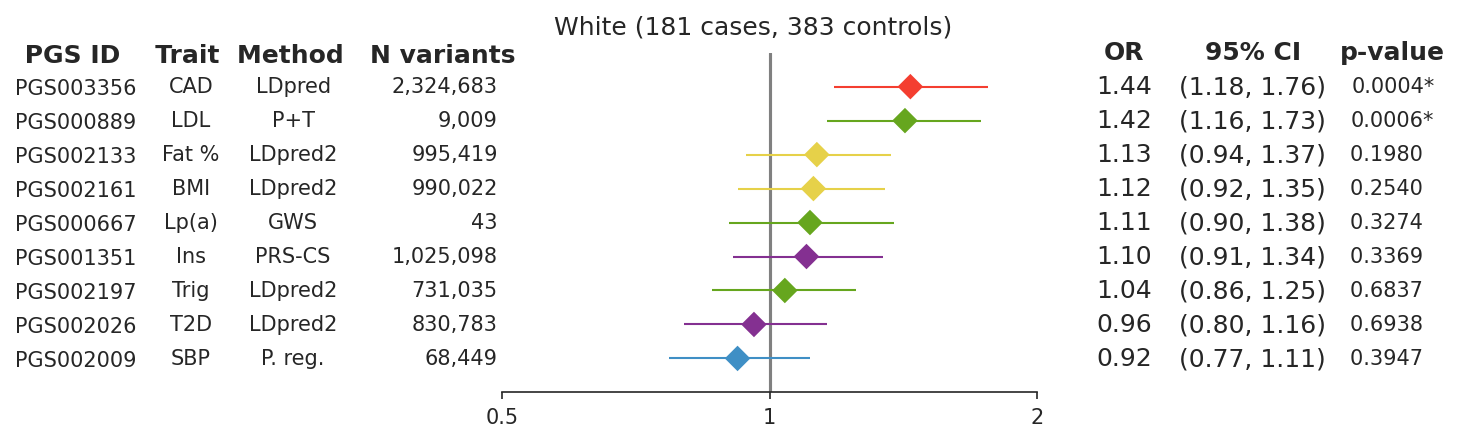

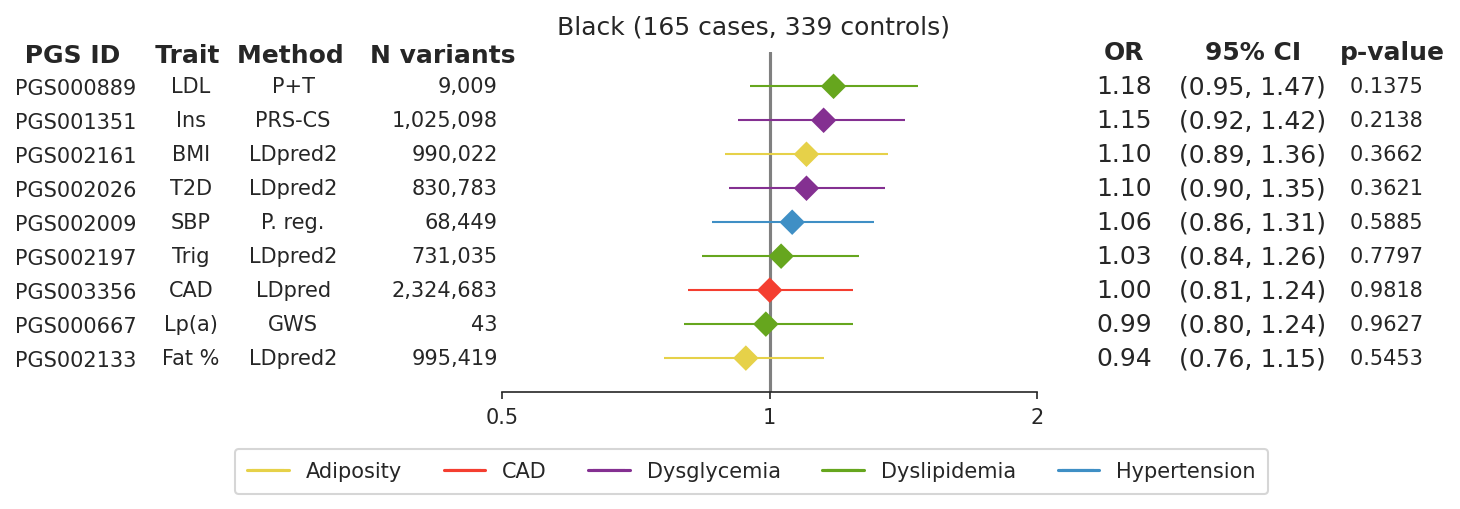

In [9]:
### Plot selected scores segregrating cohort in whites and blacks 

# Set image resolution and background
from shutil import which

plt.rcParams['figure.dpi']= 150
sns.set_style('white')

# Function to return a subset of models that will be used on the forest plot
def get_models_subset(race, reference_panel_id, grs_subset, threshold ):
    
    # Get only subset of lines that meet the criteria
    models_subset = models_summaries[ (models_summaries["race"] == race) & (models_summaries["reference_panel"] == reference_panel_id) & (models_summaries["GRS"].isin( grs_subset) ) & (models_summaries["threshold"] == threshold )]
    models_subset = models_subset.sort_values("odds_ratio", ascending=False)
    
    return( models_subset )

# Define score_info and classes of selected scores
grs_subset_and_info = {
    "PGS003356": ["CAD", "LDpred", "2,324,683", "CAD"],
    # "PGS000018": ["CAD", "metaGRS", "1,745,179", "CAD"], 
    "PGS000889": ["LDL", "P+T", "9,009", "Dyslipidemia"], 
    "PGS002133": ["Fat %", "LDpred2", "995,419", "Adiposity"],
    "PGS001351": ["Ins", "PRS-CS", "1,025,098", "Dysglycemia"], 
    "PGS002161": ["BMI", "LDpred2", "990,022", "Adiposity"], 
    "PGS000667": ["Lp(a)", "GWS", "43", "Dyslipidemia"], 
    "PGS002197": ["Trig", "LDpred2", "731,035", "Dyslipidemia"], 
    "PGS002026": ["T2D", "LDpred2", "830,783", "Dysglycemia"], 
    "PGS002009": ["SBP", "P. reg.", "68,449", "Hypertension"]
    }
class_to_color = {
    "CAD": sns.color_palette( n_colors=40, palette="CMRmap" )[19],
    "Adiposity": sns.color_palette( n_colors=40, palette="CMRmap" )[32],
    "Dysglycemia": sns.color_palette( n_colors=40, palette="CMRmap" )[13],
    "Dyslipidemia": sns.color_palette( n_colors=40, palette="Dark2" )[4],
    "Hypertension": sns.color_palette( n_colors=10, palette="Blues" )[6]
    }

for race in ['white', 'black']:

    # Subset based on criterias and save to a new dataframe
    models_subset = get_models_subset( race, "topmed", grs_subset_and_info.keys(), "r0")
    
    # Assign classes and colors to each score
    models_subset = models_subset.assign( trait_abbreviation=[ grs_subset_and_info[ elem ][0] for elem in models_subset["GRS"].to_list() ] )
    models_subset = models_subset.assign( dev_method=[ grs_subset_and_info[ elem ][1] for elem in models_subset["GRS"].to_list() ] )
    models_subset = models_subset.assign( n_variants=[ grs_subset_and_info[ elem ][2] for elem in models_subset["GRS"].to_list() ] )
    models_subset = models_subset.assign( grs_class=[ grs_subset_and_info[ elem ][3] for elem in models_subset["GRS"].to_list() ] )    
    models_subset = models_subset.assign( color=[ class_to_color[ elem ] for elem in models_subset["grs_class"].to_list() ] )
    
    # Test p-values to see if they survive to multiple testing correction (FDR)
    fdr_result = fdrcorrection( models_subset["score_pvalue"].to_list() )
    models_subset = models_subset.assign( adjusted_p=fdr_result[1] )
    models_subset = models_subset.assign( fdr_significant=fdr_result[0] )
    
    # Create plot
    p = EffectMeasurePlot(
        label=[ "{0}                                                     ".format( row["GRS"] ) for index, row in models_subset.iterrows() ], 
        effect_measure=[ "{0:.2f}".format(row["odds_ratio"]) for index, row in models_subset.iterrows() ],
        lcl=[ "{0:.2f}".format(row["conf_interval_lower"]) for index, row in models_subset.iterrows() ],
        ucl=[ "{0:.2f}".format(row["conf_interval_upper"]) for index, row in models_subset.iterrows() ]
        )
    # Adjust axis, labels, titles and frame (sets OR and CI labels to null to use bold fontweight on them)
    p.labels(effectmeasure='', conf_int='', scale='log')
    p.colors(pointshape="D", pointcolor=models_subset["color"], errorbarcolor=models_subset["color"] )
    ax=p.plot(figsize=(7,3), t_adjuster=0.05, min_value=0.5, max_value=2)    
    plt.suptitle(" PGS ID    Trait  Method   N variants", x=-0.1, y=0.90, fontweight="bold")
    number_of_cases = len( sea_dataset_full[ ( sea_dataset_full["race"] == race ) & ( sea_dataset_full["Case"] == True ) ] )
    number_of_controls = len( sea_dataset_full[ ( sea_dataset_full["race"] == race ) & ( sea_dataset_full["Case"] == False ) ] )
    plt.title("{0} ({1} cases, {2} controls)".format(race.capitalize(), number_of_cases, number_of_controls), loc="center",x=-1.2, y=1.02)
    plt.text( x=0.25, y=1, ha='center', va="center", s="OR", fontsize=12, fontweight="bold")
    plt.text( x=0.753, y=1, ha='center', va="center", s="95% CI", fontsize=12, fontweight="bold")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.tick_params( axis='x', which="minor", bottom=False )
        
    # Add right column with score p-values and mark with * the ones that survive FDR
    plt.text( x=1.3, y=1, ha='center', va="center", s="p-value", fontsize=12, fontweight="bold")
    p_value_y_pos = 0.9
    for index, row in models_subset.iterrows():
        plt.text( x=-3.4, y=p_value_y_pos, ha='center', va="center", s="{0}".format( row["trait_abbreviation"] ), fontsize=10)
        plt.text( x=-3, y=p_value_y_pos, ha='center', va="center", s="{0}".format( row["dev_method"] ), fontsize=10)
        plt.text( x=-2.2, y=p_value_y_pos, ha='right', va="center", s="{0}".format( row["n_variants"] ), fontsize=10)
        plt.text( x=1.3, y=p_value_y_pos, ha='center', va="center", s="{0:.4f}{1}".format( row["score_pvalue"], "*" if( row["fdr_significant"] ) else "  "), fontsize=10)
        p_value_y_pos-=0.1
        
# Add legend
trait_handles = []
for grs_class in sorted( set( models_subset[ "grs_class" ] )  ):
    trait_handles.append( mlines.Line2D([], [], label=grs_class, color=class_to_color[grs_class], marker='_', markersize=15) )
ax.legend(handles=trait_handles, loc=(-0.5, -0.3), shadow=False, borderpad=0.6, ncol=5)


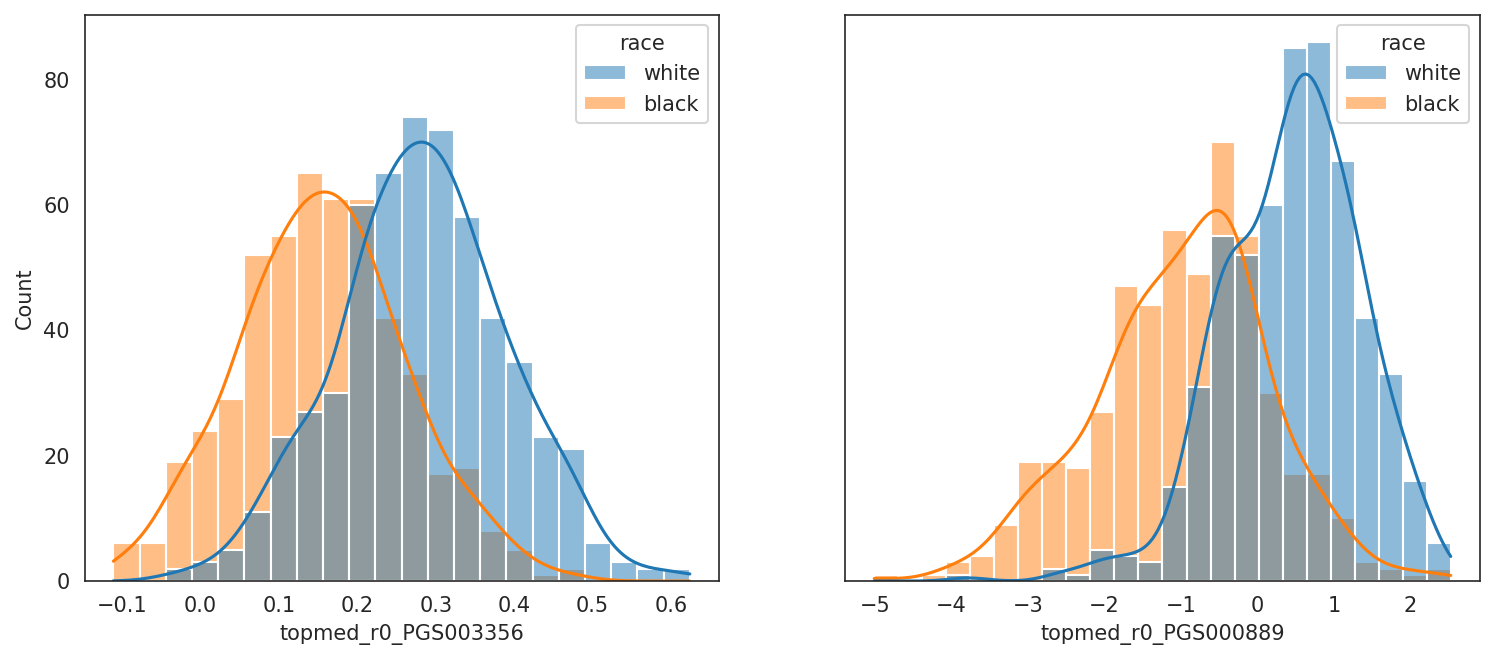

In [10]:
### Histogram plots with raw scores

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))

for score in ["topmed_r0_PGS003356", "topmed_r0_PGS000889"]:
# for score in ["topmed_r0_PGS000018", "topmed_r0_PGS000889"]:

    sns.histplot(
        x = score,
        hue = "race",
        kde=True,
        data = sea_dataset_full,
        ax = ax2 if score == "topmed_r0_PGS000889" else ax1
        )

       count  sum  cases_percentage score quantile
Q1       113   21         18.584071   CAD       Q1
Q2-Q4    338  113         33.431953   CAD    Q2-Q4
Q5       113   47         41.592920   CAD       Q5
Q1       113   28         24.778761   LDL       Q1
Q2-Q4    338  101         29.881657   LDL    Q2-Q4
Q5       113   52         46.017699   LDL       Q5
             count  min  Q_25  median   Q_75   mean   max
race  CAD                                                
white Q1        37  0.3  1.60     4.7  19.90  11.46  54.7
      Q2-Q4    108  0.3  1.17     5.7  16.60  12.62  89.5
      Q5        36  0.3  1.92     4.0  17.97  14.44  90.4
             count  min  Q_25  median   Q_75   mean   max
race  LDL                                                
white Q1        37  0.5  2.00    4.00  15.20  10.88  61.8
      Q2-Q4    108  0.3  1.37    5.00  16.30  11.96  90.4
      Q5        36  0.3  1.12    7.45  25.92  17.01  88.7


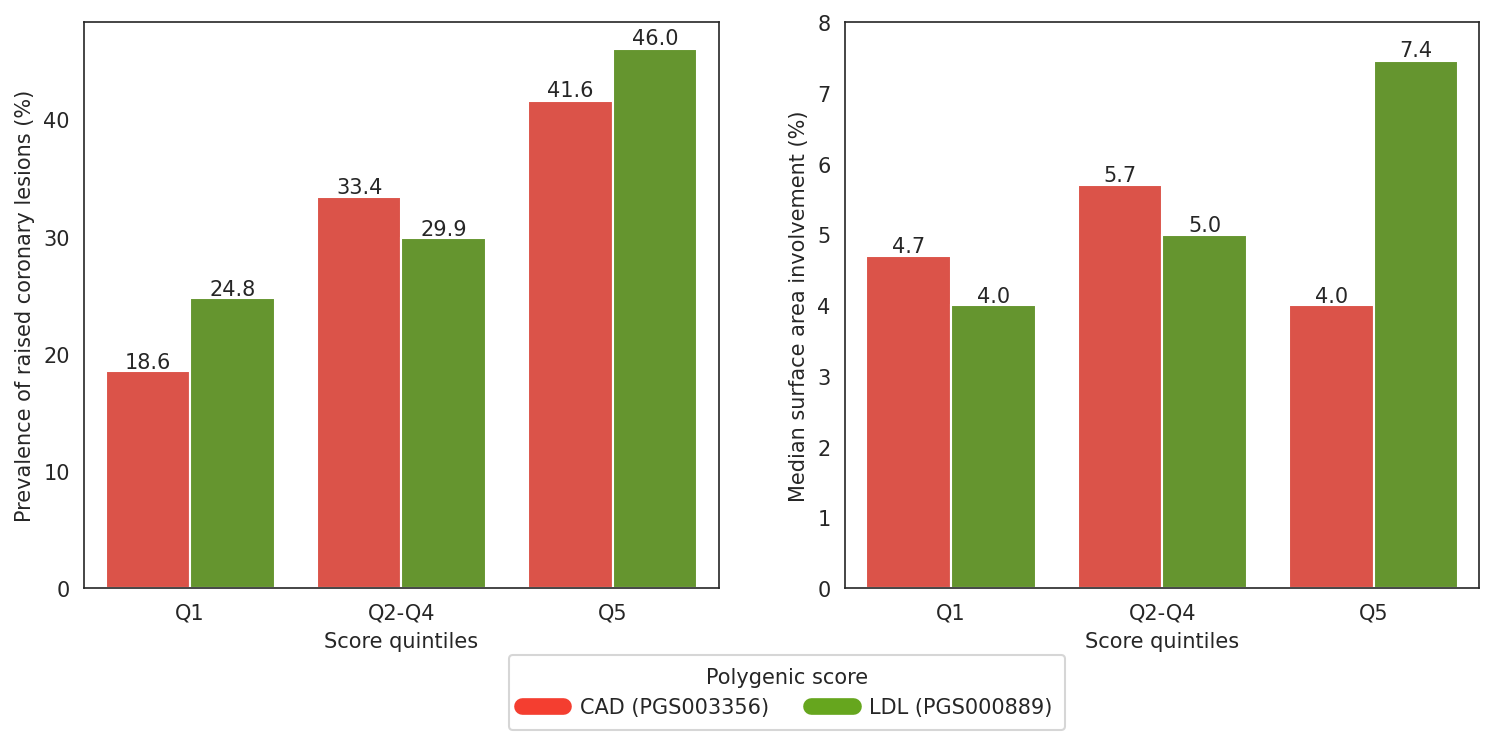

In [11]:
### Plot score quantiles using % of cohort where Case = True

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'Q_%s' % n
    return percentile_

def cases_percentage(x):
    frac = sum(x)/len(x)
    return frac

def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

# Set image resolution and background
plt.rcParams['figure.dpi']= 150
sns.set_style('white')

# Create a 2 panel plot
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(12,5))

# Define for which race subgroup to make barplots
race = "white"

## Plot score quantiles using % of cohort where Case = True

# Subset cohort to whites only
# sea_dataset_subset = sea_dataset_full
sea_dataset_subset = sea_dataset_full[ sea_dataset_full["race"] == race ]

# Split data on non equally-sized quantiles (20-60-20)
quantile_labels = ["Q1", "Q2-Q4", "Q5"]
sea_dataset_subset = sea_dataset_subset.assign( CAD=pd.qcut(sea_dataset_subset["topmed_r0_PGS003356"], [0,0.2,0.8,1], labels=quantile_labels) )
sea_dataset_subset = sea_dataset_subset.assign( LDL=pd.qcut(sea_dataset_subset["topmed_r0_PGS000889"], [0,0.2,0.8,1], labels=quantile_labels) )

cases_quantiles = pd.concat( [
        sea_dataset_subset.groupby(["CAD"])["Case"].agg( [ "count", "sum", cases_percentage ] ).assign( score="CAD", quantile=quantile_labels ),
        sea_dataset_subset.groupby(["LDL"])["Case"].agg( [ "count", "sum", cases_percentage ] ).assign( score="LDL", quantile=quantile_labels )
    ] )

# Transform value in percentage
cases_quantiles["cases_percentage"] = cases_quantiles["cases_percentage"] * 100

# Print some basic statistics
print( cases_quantiles )
    
# Plot 
p = sns.barplot(
    x = "quantile",
    y = "cases_percentage",
    hue = "score",
    ci = None,
    palette = {
        "CAD": sns.color_palette( n_colors=40, palette="CMRmap" )[19],
        "LDL": sns.color_palette( n_colors=40, palette="Dark2" )[4]
    },
    data = cases_quantiles,
    ax = ax1
    )

# Change axis labels
p.set( xlabel = "Score quintiles", ylabel = "Prevalence of raised coronary lesions (%)" )

# Display value on top of barplots
show_values(p)
 
## Plot score quantiles using median % of surface with RC (only CR+ cases)

# Subset cohort to whites only
# sea_dataset_subset = sea_dataset_full
sea_dataset_subset = sea_dataset_full[ ( sea_dataset_full["race"] == race ) & (sea_dataset_full["Case"] == True) ]

# Split data on non equally-sized quantiles (20-60-20)
quantile_labels = ["Q1", "Q2-Q4", "Q5"]
sea_dataset_subset = sea_dataset_subset.assign( CAD=pd.qcut(sea_dataset_subset["topmed_r0_PGS003356"], [0,0.2,0.8,1], labels=quantile_labels) )
sea_dataset_subset = sea_dataset_subset.assign( LDL=pd.qcut(sea_dataset_subset["topmed_r0_PGS000889"], [0,0.2,0.8,1], labels=quantile_labels) )

# Print some basic statistics
y_variable = "cr"
print( sea_dataset_subset.groupby( [ "race", "CAD" ] )[y_variable].agg( [ "count", "min", percentile(25), "median", percentile(75), "mean", "max",  ] ).round(2) )
print( sea_dataset_subset.groupby( [ "race", "LDL" ] )[y_variable].agg( [ "count", "min", percentile(25), "median", percentile(75), "mean", "max",  ] ).round(2) )

# Generate barplot of score quantiles using median % of surface with RC
p = sns.barplot(
    x = 'value',
    y = y_variable,
    hue = 'variable',
    ci = None,
    estimator=np.median,
    order = quantile_labels,
    palette = {
        "CAD": sns.color_palette( n_colors=40, palette="CMRmap" )[19],
        "LDL": sns.color_palette( n_colors=40, palette="Dark2" )[4]
        },
    data = pd.melt( sea_dataset_subset, id_vars=[y_variable], value_vars=['CAD', 'LDL'], ignore_index=False ),
    ax = ax2
    )

# Change axis labels and ranges
# p.set( xlabel="Score quintiles", ylabel="Mean surface area involvement (%)", ylim=(0,18) )
p.set( xlabel="Score quintiles", ylabel="Median surface area involvement (%)", ylim=(0,8) )

# Display value on top of barplots
show_values(p)

# Add a single legend for both panels
trait_handles = []
trait_handles.append( mlines.Line2D([], [], label="CAD (PGS003356)", color=sns.color_palette( n_colors=40, palette="CMRmap" )[19], lw=8) )
trait_handles.append( mlines.Line2D([], [], label="LDL (PGS000889)", color=sns.color_palette( n_colors=40, palette="Dark2" )[4], lw=8) )
ax1.legend_.remove()
ax2.legend( title="Polygenic score", handles=trait_handles, loc=(-0.53, -0.25), shadow=False, borderpad=0.6, ncol=3 )

Extra: Test interaction term **score*race**

In [12]:
# Run score with LDL+CAD for whites to assess integration of various PRSs into a single model

li = []
models_summaries = pd.DataFrame()

# Subset white cohort to run logistic regression individually
sea_dataset_subset = sea_dataset_full[ sea_dataset_full["race"] == "white" ]

# Create a dependent variable named "Case_recoded" based on column "Case", conding it as 0 and 1 to fit glm
sea_dataset_subset = sea_dataset_subset.assign( Case_recoded=sea_dataset_subset["Case"].replace(True, 1).replace(False, 0) )

for grs in [ 'PGS000889', 'PGS003356' ]:

    raw_score_name = "_".join( ("topmed", "r0", grs ) )
    standardize_score_name = "_".join( ("white", "topmed", "r0", grs) )
        
    # Standardize raw scores using method scale
    sea_dataset_subset[ standardize_score_name ] = preprocessing.scale( sea_dataset_subset[ raw_score_name ] )

# Fit a logistic model using standardize scores and save it
logit_model_LDL_CAD = sm.formula.glm(
"Case_recoded ~ white_topmed_r0_PGS000889 + white_topmed_r0_PGS003356 + age + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",
    family=sm.families.Binomial(),
    data=sea_dataset_subset).fit()

print( logit_model_LDL_CAD.summary() )

# Transform values to OR, pvalue and CI
li = []

for model_variable in [ "white_topmed_r0_PGS000889", "white_topmed_r0_PGS003356" ]:

    model_variable_series = {
    "odds_ratio": np.exp( logit_model_LDL_CAD.params )[ model_variable ],
    "score_pvalue": logit_model_LDL_CAD.pvalues[ model_variable ],
    "conf_interval_lower": np.exp( logit_model_LDL_CAD.conf_int()[0][ model_variable ] ),
    "conf_interval_upper": np.exp( logit_model_LDL_CAD.conf_int()[1][ model_variable ] )
    }

    # Transform dictionary on a pandas Series and name it as <standardize_score_name>
    model_summary_series = pd.Series(
        data=model_variable_series,
        name=model_variable
    )
    
    li.append( model_summary_series )
    
# Concatenate results for all models tested and transpose object to make visualization easier 
models_summaries = pd.concat( li, axis=1 ).transpose().sort_values("odds_ratio", ascending=False)

models_summaries

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Case_recoded   No. Observations:                  564
Model:                            GLM   Df Residuals:                      549
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -316.27
Date:                Mon, 30 Jan 2023   Deviance:                       632.54
Time:                        17:07:48   Pearson chi2:                     563.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

,odds_ratio,score_pvalue,conf_interval_lower,conf_interval_upper
white_topmed_r0_PGS003356,1.376275,0.002176,1.122046,1.688107
white_topmed_r0_PGS000889,1.353766,0.003559,1.104312,1.659571


In [13]:
### Test interaction term score*race

# Standardize raw scores and calculate OR

li = []
standardize_scores = []
logit_models_interaction_dict = {}
models_summaries_interaction = pd.DataFrame()

# Get list of panels, thresholds and GRSs used from info dictonary
reference_panels = set( [ key.split('_')[0] for key in scores_info_dict.keys() ] )
thresholds = set( [ key.split('_')[1] for key in scores_info_dict.keys() ] )
grss = set( [ key.split('_')[2] for key in scores_info_dict.keys() ] )

# For interaction term testing, we are testing the full cohort (whites and blacks) together. 
sea_dataset_test_interaction = sea_dataset_full

# Create a dependent variable named "Case_recoded" based on column "Case", conding it as 0 and 1 to fit glm
sea_dataset_test_interaction = sea_dataset_test_interaction.assign( Case_recoded=sea_dataset_test_interaction["Case"].replace(True, 1).replace(False, 0) )

for reference_panel_id in reference_panels:
    
    for threshold in thresholds:

        for grs in grss:

            raw_score_name = "_".join( (reference_panel_id, threshold, grs) )
            standardize_score_name = "_".join( (reference_panel_id, threshold, grs) )
            standardize_scores.append(standardize_score_name)
        
            # Standardize raw scores using method scale (mean = 0 and SD = 1)
            sea_dataset_test_interaction[ standardize_score_name ] = preprocessing.scale( sea_dataset_test_interaction[ raw_score_name ] )
        
            # Fit a logistic model using standardize scores testing for interaction between score and race 
            logit_models_interaction_dict[ standardize_score_name ] = sm.formula.glm(
                # "Case_recoded ~ " + standardize_score_name + "*race + age + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",
                "Case_recoded ~ " + standardize_score_name + " + race + age + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10",
                family=sm.families.Binomial(),
                data=sea_dataset_test_interaction).fit()

            # Create dictonary with scores performances
            model_summary_series = {
                    "model_ref": raw_score_name,
                    "reference_panel": reference_panel_id,
                    "threshold": threshold,
                    "GRS": grs,
                    "odds_ratio": np.exp( logit_models_interaction_dict[ standardize_score_name ].params )[ standardize_score_name ],
                    "score_pvalue": logit_models_interaction_dict[ standardize_score_name ].pvalues[ standardize_score_name ],
                    "conf_interval_lower": np.exp( logit_models_interaction_dict[ standardize_score_name ].conf_int()[0][ standardize_score_name ] ),
                    "conf_interval_upper": np.exp( logit_models_interaction_dict[ standardize_score_name ].conf_int()[1][ standardize_score_name ] )
                }
                
            # Add metadata about the GRSs to the output
            model_summary_series.update( pgs_metadata[grs] )
                
            # Transform dictionary on a pandas Series and name it as <standardize_score_name>
            model_summary_series = pd.Series(
                data=model_summary_series,
                name=standardize_score_name
            )
                                
            li.append(model_summary_series)
                     
# Concatenate results for all models tested and transpose object to make visualization easier 
models_summaries_interaction = pd.concat( li, axis=1 ).transpose().sort_values("odds_ratio", ascending=False)

# Move trait_mapped column to first position to facilitate analysis of excel results
columns_order = models_summaries_interaction.columns.drop("trait_mapped").tolist()
columns_order.insert(0,"trait_mapped")
models_summaries_interaction = models_summaries_interaction.reindex(columns=columns_order, copy=False)
# models_summaries_interaction


# List of GRS to print results
grs_subset = [ "PGS000018", "PGS000889", "PGS002133", "PGS001351", "PGS002161", "PGS000667", "PGS002197", "PGS002009", "PGS002026" ]

for grs_id in grs_subset:
    full_grs_id = "topmed_r0_" + grs_id
    print( ">>> ",  full_grs_id , "\n", logit_models_interaction_dict[ full_grs_id ].summary(), "\n")

# # SIRE logist 
# grs_id = "white_topmed_r0_PGS000018"; print( ">>> ", grs_id, "\n", logit_models_dict[ grs_id ].summary(), "\n")
# grs_id = "black_topmed_r0_PGS000018"; print( ">>> ", grs_id, "\n", logit_models_dict[ grs_id ].summary(), "\n")

# # Interaction score*sire
# grs_id = "topmed_r0_PGS000018"; print( ">>> ", grs_id, "\n", logit_models_interaction_dict[ grs_id ].summary(), "\n")
# grs_id = "topmed_r0_PGS000889"; print( ">>> ", grs_id, "\n", logit_models_interaction_dict[ grs_id ].summary(), "\n")
# grs_id = "topmed_r0_PGS002133"; print( ">>> ", grs_id, "\n", logit_models_interaction_dict[ grs_id ].summary(), "\n")
# grs_id = "topmed_r0_PGS002161"; print( ">>> ", grs_id, "\n", logit_models_interaction_dict[ grs_id ].summary(), "\n")

# print( logit_models_interaction_dict[ "" ].summary() )
# print( logit_models_interaction_dict[ "topmed_r0_PGS000018" ].summary() )



>>>  topmed_r0_PGS000018 
                  Generalized Linear Model Regression Results                  
Dep. Variable:           Case_recoded   No. Observations:                 1068
Model:                            GLM   Df Residuals:                     1053
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -611.22
Date:                Mon, 30 Jan 2023   Deviance:                       1222.4
Time:                        17:08:16   Pearson chi2:                 1.09e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Interce

[Text(0.5, 1.0, 'Raised coronary lesions (white=564, black=504)'),
 Text(0.5, 0, 'Surface area involvement (%)')]

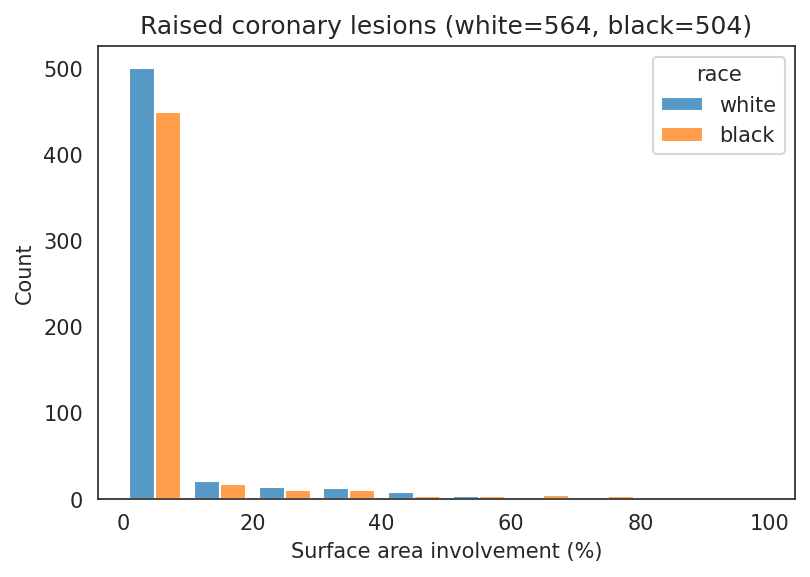

In [14]:
# Set image resolution and background
plt.rcParams['figure.dpi']= 150
sns.set_style('white')

# for dataset in sea_phenotypes, sea_phenotypes[sea_phenotypes["cr"] > 0]: 
# for dataset in sea_phenotypes, sea_phenotypes:

plot_dataset = sea_phenotypes
# plot_dataset = sea_phenotypes[sea_phenotypes["cr"] > 0]

n_white = len( plot_dataset[plot_dataset["race"] == "white"] )
n_black = len( plot_dataset[plot_dataset["race"] == "black"] )

sns.histplot(
       x = "cr",
       data = plot_dataset,
       hue="race",
       multiple="dodge",
       shrink=0.8,
       # log_scale=(False,True),
       # bins=[0,1,5,20,50,100],
       binrange=(0,100),
       binwidth=10
       ).set( 
             title='Raised coronary lesions (white={0}, black={1})'.format( n_white, n_black ), 
             xlabel="Surface area involvement (%)"
             )

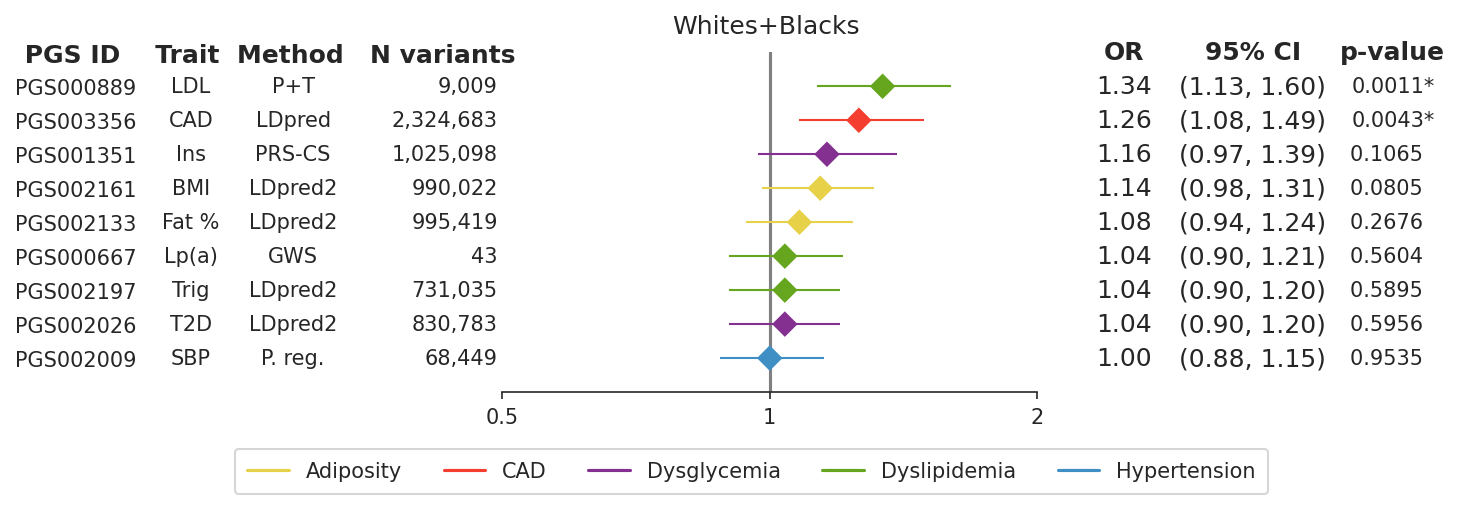

In [16]:
### Plot selected scores without segregrating cohort in whites and blacks 

# Set image resolution and background
plt.rcParams['figure.dpi']= 150
sns.set_style('white')

# Function to return a subset of models that will be used on the forest plot
def get_models_subset(reference_panel_id, grs_subset, threshold ):
    
    # Get only subset of lines that meet the criteria
    models_subset = models_summaries_interaction[ (models_summaries_interaction["reference_panel"] == reference_panel_id) & (models_summaries_interaction["GRS"].isin( grs_subset) ) & (models_summaries_interaction["threshold"] == threshold )]
    models_subset = models_subset.sort_values("odds_ratio", ascending=False)
    
    return( models_subset )

# Define score_info and classes of selected scores
grs_subset_and_info = {
    "PGS003356": ["CAD", "LDpred", "2,324,683", "CAD"],
    # "PGS000018": ["CAD", "metaGRS", "1,745,179", "CAD"], 
    "PGS000889": ["LDL", "P+T", "9,009", "Dyslipidemia"], 
    "PGS002133": ["Fat %", "LDpred2", "995,419", "Adiposity"],
    "PGS001351": ["Ins", "PRS-CS", "1,025,098", "Dysglycemia"], 
    "PGS002161": ["BMI", "LDpred2", "990,022", "Adiposity"], 
    "PGS000667": ["Lp(a)", "GWS", "43", "Dyslipidemia"], 
    "PGS002197": ["Trig", "LDpred2", "731,035", "Dyslipidemia"], 
    "PGS002026": ["T2D", "LDpred2", "830,783", "Dysglycemia"], 
    "PGS002009": ["SBP", "P. reg.", "68,449", "Hypertension"]
    }
class_to_color = {
    "CAD": sns.color_palette( n_colors=40, palette="CMRmap" )[19],
    "Adiposity": sns.color_palette( n_colors=40, palette="CMRmap" )[32],
    "Dysglycemia": sns.color_palette( n_colors=40, palette="CMRmap" )[13],
    "Dyslipidemia": sns.color_palette( n_colors=40, palette="Dark2" )[4],
    "Hypertension": sns.color_palette( n_colors=10, palette="Blues" )[6]
    }

# Subset based on criterias and save to a new dataframe
models_subset = get_models_subset( "topmed", grs_subset_and_info.keys(), "r0")

# Assign classes and colors to each score
models_subset = models_subset.assign( trait_abbreviation=[ grs_subset_and_info[ elem ][0] for elem in models_subset["GRS"].to_list() ] )
models_subset = models_subset.assign( dev_method=[ grs_subset_and_info[ elem ][1] for elem in models_subset["GRS"].to_list() ] )
models_subset = models_subset.assign( n_variants=[ grs_subset_and_info[ elem ][2] for elem in models_subset["GRS"].to_list() ] )
models_subset = models_subset.assign( grs_class=[ grs_subset_and_info[ elem ][3] for elem in models_subset["GRS"].to_list() ] )    
models_subset = models_subset.assign( color=[ class_to_color[ elem ] for elem in models_subset["grs_class"].to_list() ] )
    
# Test p-values to see if they survive to multiple testing correction (FDR)
fdr_result = fdrcorrection( models_subset["score_pvalue"].to_list() )
models_subset = models_subset.assign( adjusted_p=fdr_result[1] )
models_subset = models_subset.assign( fdr_significant=fdr_result[0] )

# Create plot
p = EffectMeasurePlot(
    label=[ "{0}                                                     ".format( row["GRS"] ) for index, row in models_subset.iterrows() ], 
    effect_measure=[ "{0:.2f}".format(row["odds_ratio"]) for index, row in models_subset.iterrows() ],
    lcl=[ "{0:.2f}".format(row["conf_interval_lower"]) for index, row in models_subset.iterrows() ],
    ucl=[ "{0:.2f}".format(row["conf_interval_upper"]) for index, row in models_subset.iterrows() ]
    )
# # Adjust axis, labels, titles and frame (sets OR and CI labels to null to use bold fontweight on them)
p.labels(effectmeasure='', conf_int='', scale='log')
p.colors(pointshape="D", pointcolor=models_subset["color"], errorbarcolor=models_subset["color"] )
ax=p.plot(figsize=(7,3), t_adjuster=0.05, min_value=0.5, max_value=2)    
plt.suptitle(" PGS ID    Trait  Method   N variants", x=-0.1, y=0.90, fontweight="bold")
plt.title("Whites+Blacks", loc="center",x=-1.15, y=1.02)
plt.text( x=0.25, y=1, ha='center', va="center", s="OR", fontsize=12, fontweight="bold")
plt.text( x=0.753, y=1, ha='center', va="center", s="95% CI", fontsize=12, fontweight="bold")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)
ax.tick_params( axis='x', which="minor", bottom=False )

# Add right column with score p-values and mark with * the ones that survive FDR
plt.text( x=1.3, y=1, ha='center', va="center", s="p-value", fontsize=12, fontweight="bold")

p_value_y_pos = 0.9
for index, row in models_subset.iterrows():
    plt.text( x=-3.4, y=p_value_y_pos, ha='center', va="center", s="{0}".format( row["trait_abbreviation"] ), fontsize=10)
    plt.text( x=-3, y=p_value_y_pos, ha='center', va="center", s="{0}".format( row["dev_method"] ), fontsize=10)
    plt.text( x=-2.2, y=p_value_y_pos, ha='right', va="center", s="{0}".format( row["n_variants"] ), fontsize=10)
    plt.text( x=1.3, y=p_value_y_pos, ha='center', va="center", s="{0:.4f}{1}".format( row["score_pvalue"], "*" if( row["fdr_significant"] ) else "  "), fontsize=10)
    p_value_y_pos-=0.1
        
# Add legend
trait_handles = []
for grs_class in sorted( set( models_subset[ "grs_class" ] )  ):
    trait_handles.append( mlines.Line2D([], [], label=grs_class, color=class_to_color[grs_class], marker='_', markersize=15) )
ax.legend(handles=trait_handles, loc=(-0.5, -0.3), shadow=False, borderpad=0.6, ncol=5)


<h2>Extra analysis</h2>

Extra 1: Plot boxplots and histograms and boxplots of raw scores spliting by sex

In [ ]:
# Plot boxplots and histograms and boxplots of raw scores spliting by sex

sns.set_style('whitegrid')

score_list = ["wGRS49_r0", "wGRS49_r03", "wGRS49_r05", "wGRS49_r08"]
# score_list = ["PGS000349_r0", "PGS000349_r03", "PGS000349_r05", "PGS000349_r08"]
# score_list = ["PGS000018_r0", "PGS000018_r03", "PGS000018_r05", "PGS000018_r08"]

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(5*len(score_list),12))
for i in range(0, len(score_list)):
    sns.boxplot(
        x = "Case",
        y = score_list[i],
        data = sea_merged_whites,
        palette = reversed(sns.color_palette(n_colors=2)),
        width=0.4,
        fliersize=2,
        ax=axs[0,i],
    )
    sns.histplot(
        x = score_list[i],
        data = sea_merged_whites[ sea_merged_whites["sex"] == "Male" ],
        hue="Case",
        hue_order=[True, False],
        kde=True,
        ax=axs[1,i]
        ).set(title='Males (n={0})'.format( sum( sea_merged_whites["sex"] == "Male" ) ) )
    sns.histplot(
        x = score_list[i],
        data = sea_merged_whites[ sea_merged_whites["sex"] == "Female" ],
        hue="Case",
        hue_order=[True, False],
        kde=True,
        ax=axs[2,i]
    ).set(title='Females (n={0})'.format( sum( sea_merged_whites["sex"] == "Female" ) ) )

plt.subplots_adjust(top=1.25)

# # Plot only boxplots

# fig, axs = plt.subplots(ncols=len(score_list), figsize=(5*len(score_list),4))
# for i in range(0, len(score_list)):
#     sns.boxplot(
#         x = "Case",
#         y = score_list[i],
#         data = sea_merged_whites,
#         hue="sex",
#         hue_order=['Male','Female'],
#         width=0.4,
#         fliersize=2,
#         ax=axs[i],
#     )

Extra 2: Compare OR from models with 5 PCs and 10 PCs

In [ ]:
# Need to run model calculation twice (5 PCs and 10 PCs) to be able to complete the cell on this analysis

# models_summaries_10pcs = models_summaries
# models_summaries_5pcs = models_summaries

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi']= 150

sns.set_style('whitegrid')

pandas_5_10_pcs = pd.concat( [models_summaries_5pcs.add_suffix("_5PCs"), models_summaries_10pcs.add_suffix("_10PCs")], axis=1 )
pandas_5_10_pcs

# Create a column named race to use in plotting
pandas_5_10_pcs["race"] = pandas_5_10_pcs["race_5PCs"]

# Cast variables to float for plotting
pandas_5_10_pcs = pandas_5_10_pcs.astype( {
    "odds_ratio_5PCs": float,
    "odds_ratio_10PCs": float,
    "score_pvalue_5PCs": float
    } )

# Plot regression plot
sns.lmplot(
    x = "odds_ratio_5PCs",
    y = "odds_ratio_10PCs",
    data = pandas_5_10_pcs[ pandas_5_10_pcs["score_pvalue_10PCs"] <= 0.05 ],
    # data = pandas_5_10_pcs,
    hue="race", 
    scatter_kws={'s':50, 'alpha':0.5},
    line_kws={'lw':2.5, 'ls': '--'}
    )

# Set x and y limits and a diagonal line
axes_limits=(0.7, 1.6)
plt.plot(axes_limits, axes_limits, c='black', alpha=0.8, lw=1)

Extra 3: Calculate and plot beta differences by R thresholds for each model, panel, race

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Clone models_summaries adding a new column named beta_diff
beta_diffs = models_summaries.assign( beta_diff=np.nan )

# Function to return OR value for a given model
def get_beta_value(race, reference_panel_id, grs, threshold ):
    
    # Get OR value for a given model
    or_value = models_summaries[ (models_summaries["race"] == race) & (models_summaries["reference_panel"] == reference_panel_id) & (models_summaries["GRS"] == grs ) & (models_summaries["threshold"] == threshold )]["odds_ratio"]
    
    # Transform OR to Beta
    beta_value = math.log( or_value ) 
    
    return( beta_value )

# Loop over multiple models to get differences on betas
for race in models_summaries['race'].unique().tolist():
        
    for reference_panel_id in models_summaries['reference_panel'].unique().tolist():
        
        for grs in models_summaries['GRS'].unique().tolist():
            
            # Get baseline beta (r = 0)
            baseline_beta = get_beta_value( race, reference_panel_id, grs, "r0" )
            
            for threshold in models_summaries['threshold'].unique().tolist():
                
                r_beta = get_beta_value( race, reference_panel_id, grs, threshold )
                
                beta_diffs.loc[ "_".join( [race, reference_panel_id, threshold, grs] ) , "beta_diff"] = r_beta - baseline_beta
                

# Plot betas differences for each model | panel

plt.rcParams['figure.dpi']= 100

sns.set_style('whitegrid')

g = sns.FacetGrid(
    beta_diffs, 
    row="GRS",
    col="reference_panel",
    sharex=False,
    hue = "race",
    hue_order=['white','black']
    )

g.map_dataframe(
    sns.stripplot,
    x = "threshold",
    y = "beta_diff",
    order = ['r0', 'r03', 'r05', 'r08']
    )

g.set_titles( col_template="{col_name}", row_template="{row_name}" )

g.add_legend()